In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kernel SHAP Implementation

In [2]:
class SHAPkernel:
    mask = []
    
    def __init__(self, X, y, model, nsample=50):
        self.X = X
        self.y = y
        self.model = model
        self.nsample = nsample
        
    def combinationMask(self,features_num):
        arr_len = -1
        mask = []
        
        for i in range(2**features_num-1,-1,-1):
            binary_rep = bin(i).split("b")[-1]
            
            #First time initialisation only
            if arr_len == -1:
                arr_len = len(binary_rep)
                
            mask.append([int(j) for j in binary_rep.rjust(arr_len,"0")])
            
        # delete extreme masks, to make sure weighting function denominator isnt zero
        # As noted in the paper too.
        mask.remove([1,]*arr_len) 
        mask.remove([0,]*arr_len) 
                
        return np.array(mask)
    
    def combination(self, n, r):
        def factorial(n):
            prod = 1
            for i in range(1, n+1):
                 prod *= i 
            return prod
        return factorial(n) / (factorial(n-r) * factorial(r))
    
    def weightage(self, indv_mask):
        M = len(indv_mask)
        z = sum(indv_mask)
        
        return (M - 1) / (self.combination(M,z) * z * (M - z))
    
    def linearRegression(self, X_row, y, masks):
        X_row = np.array(X_row)
        y = np.array(y)
        
        self.masks = masks
        W = np.array([self.weightage(indv_mask) for indv_mask in masks])
        W = np.diag(W)
        
        #print("zero mask",(masks==0).shape)
        #print("mean data",np.array(self.X.mean()).shape)
        #print("data with 0s",(X_row * masks).shape)
        
        sample = np.matrix(self.X)
        
        #print(sample.shape)
        generated_dataset = (np.array(sample[0]) * (masks==0)) + (X_row * masks)
        for row in sample[1:]:
            #print((np.array(row) * (masks==0))[3])
            #print((X_row * masks)[3])
            #print("")
            generated_dataset = np.vstack((generated_dataset, 
                                           (np.array(row) * (masks==0)) + (X_row * masks)
                                         ))
        
        X = masks
        y = self.model.predict(generated_dataset)
        self.generated_dataset = generated_dataset
        #print(type(y),y.shape)
        expectaion = {}
        for ind, y_val in enumerate(y):
            if ind%32766 not in expectaion.keys():
                expectaion[ind%32766] = []
            expectaion[ind%32766].append(y_val)
        y = np.matrix([np.mean(expectaion[i]) for i in range(32766)]).T
        #print(X.shape)
        #print(type(y),y.shape)
        #print(y)
        Beta0 = self.model.predict(np.matrix((np.array(self.X.mean()))))
        
        y = y - Beta0
        
        SHAP_values = np.dot(np.linalg.inv(np.dot(np.dot(X.transpose(), W), X)), np.dot(np.dot(X.transpose(), W), y))
        
        return SHAP_values
    
    def getSHAPvalues(self, datapoint):
        masks = self.combinationMask(self.X.shape[1])
        res = self.linearRegression(datapoint, self.y, masks)
        return res

# Training Model

### Dataset Class to treat dataset with missing values

In [3]:
class Dataset:
    def __init__(self, data, y):
        numrc_cols = []
        for col, val in zip((data.dtypes!="object").index,data.dtypes!="object"):
            if val == True:
                numrc_cols.append(col)
        #Only including subset of the features, as including all features will take a lot of time to run (multiple hours)
        data = data.loc[:100,numrc_cols[1:16]+[y,]]


        #Imputing Missing Data
        for col in data:
            if data[col].dtypes=="object":
                data[col].fillna(data[col].mode()[0], inplace = True)
            else:
                data[col].fillna(data[col].mean(), inplace = True)
            
        self.dataset = data
        self.y = y
        
        self.X = self.dataset.loc[:,self.dataset.columns!=self.y]
        self.y = self.dataset.loc[:,self.dataset.columns==self.y]
        
        self.Xmean = np.array(self.X.mean())
        
    def get_dataset(self):
        return self.X, self.y

#### Training using Linear Regression model

In [4]:
from sklearn import linear_model

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test["SalePrice"] = 0 #Dummy variable to make sure both test and train dataset have same size

#Seting up training data
D_train = Dataset(train,"SalePrice")
X_train, y_train = D_train.get_dataset()

#Seting up testing data
#D_test = Dataset(test,"SalePrice")
#X_test, y_test = D_test.get_dataset()

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression()

# Explaning predictions

#### Using KernelSHAP we explain the importance of each feature for a particular instance, to arrive at the regression models result

In [5]:
kshap = SHAPkernel(X_train, y_train, regr)

In [6]:
import shap # For comparision

explainer = shap.KernelExplainer(regr.predict, X_train)
shap_values = explainer.shap_values(X_train)

Using 101 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/101 [00:00<?, ?it/s]

In [9]:
def Get_Explaination(row):
    res = kshap.getSHAPvalues(X_train.iloc[row,:])
    
    comparison = pd.DataFrame()
    comparison["correct values"] = shap_values[0][row]
    comparison["correct values"] = round(comparison["correct values"],2)
    
    comparison["implementation values"] = pd.Series([i[0] for i in np.array(res)])
    comparison["implementation values"] = round(comparison["implementation values"],2)
    
    comparison.index = X_train.columns
    
    comparison.loc[abs(comparison["implementation values"]) < 1000,:] = 0
    """
    As the shap library straightaway gives 0 shapley values, where ever the shapley values are relatively minor
    """
    
    comparison["difference(%)"] = abs(comparison["correct values"] - comparison["implementation values"])*100/abs(comparison["implementation values"])
    comparison["difference(%)"] = comparison["difference(%)"].fillna(0)
    comparison["difference(%)"] = round(comparison["difference(%)"],2)
    comparison["difference(%)"] = comparison["difference(%)"].astype("str") 
    comparison["difference(%)"] = comparison["difference(%)"]+"%"
    
    fig, axs = plt.subplots(1, 2)
    
    blank = comparison["correct values"].cumsum().shift(1).fillna(0)
    comparison["correct values"].plot(kind='bar',stacked=True, bottom=blank, title="(Linear Regression)correct values", ylabel="SHAP values",
                                     color=(comparison["correct values"] > 0).map({True: 'g', False: 'r'}),
                                     ax = axs[0])
    
    
    blank = comparison["implementation values"].cumsum().shift(1).fillna(0)
    comparison["implementation values"].plot(kind='bar',stacked=True, bottom=blank, title="(Linear Regression)implementation values", ylabel="SHAP values",
                                            color=(comparison["implementation values"] > 0).map({True: 'g', False: 'r'}),
                                            ax = axs[1])
    plt.subplots_adjust(left=0,right=1.5)
    plt.show()
    fig.savefig('regression_result.pdf',bbox_inches ="tight")
    
    return comparison

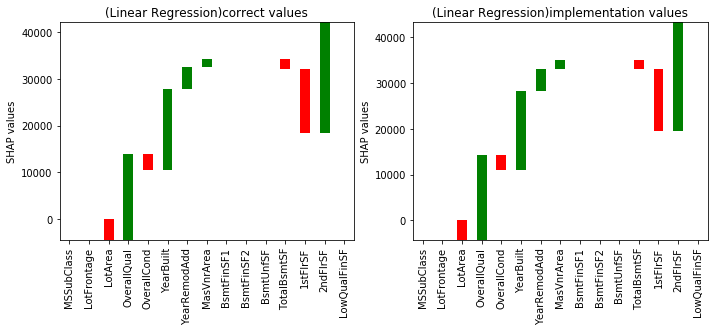

,correct values,implementation values,difference(%)
MSSubClass,0.00,0.00,0.0%
LotFrontage,0.00,0.00,0.0%
LotArea,-4385.58,-4250.25,3.18%
OverallQual,18377.94,18515.40,0.74%
OverallCond,-3373.73,-3260.49,3.47%
YearBuilt,17141.08,17268.54,0.74%
YearRemodAdd,4705.86,4863.26,3.24%
MasVnrArea,1775.10,1890.75,6.12%
BsmtFinSF1,0.00,0.00,0.0%
BsmtFinSF2,0.00,0.00,0.0%


In [10]:
Get_Explaination(0)

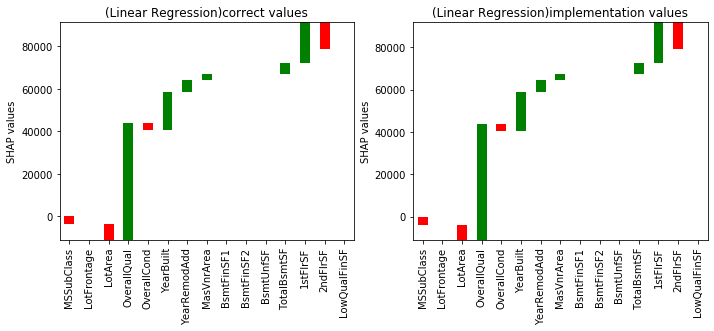

,correct values,implementation values,difference(%)
MSSubClass,-3824.85,-3788.61,0.96%
LotFrontage,0.00,0.00,0.0%
LotArea,-7205.72,-7142.79,0.88%
OverallQual,54748.77,54827.17,0.14%
OverallCond,-3317.18,-3260.49,1.74%
YearBuilt,18294.13,18363.75,0.38%
YearRemodAdd,5306.77,5377.59,1.32%
MasVnrArea,3078.09,3146.44,2.17%
BsmtFinSF1,0.00,0.00,0.0%
BsmtFinSF2,0.00,0.00,0.0%


In [11]:
Get_Explaination(34)

# Training Model

#### Training using XGBoost model

In [12]:
import xgboost as xgb

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test["SalePrice"] = 0 #Dummy variable to make sure both test and train dataset have same size

#Seting up training data
D_train = Dataset(train,"SalePrice")
X_train, y_train = D_train.get_dataset()

#Seting up testing data
#D_test = Dataset(test,"SalePrice")
#X_test, y_test = D_test.get_dataset()

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                             colsample_bytree = 0.3, 
                             learning_rate = 0.1,
                             max_depth = 5, 
                             alpha = 10, 
                             n_estimators = 5000)

# Train the model using the training sets
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Explaning predictions

#### Using KernelSHAP we explain the importance of each feature for a particular instance, to arrive at the XGB models result

In [13]:
kshap = SHAPkernel(X_train, y_train, xgb_model)

In [14]:
import shap # For comparision

explainer = shap.KernelExplainer(xgb_model.predict, X_train)
shap_values = explainer.shap_values(X_train)#, nsamples=50)

Using 101 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/101 [00:00<?, ?it/s]

In [15]:
def Get_Explaination(row):
    res = kshap.getSHAPvalues(X_train.iloc[row,:])
    
    comparison = pd.DataFrame()
    comparison["correct values"] = shap_values[row]
    comparison["correct values"] = round(comparison["correct values"],2)
    
    comparison["implementation values"] = pd.Series([i[0] for i in np.array(res)])
    comparison["implementation values"] = round(comparison["implementation values"],2)
    
    comparison.index = X_train.columns
    
    comparison.loc[abs(comparison["implementation values"]) < 1000,:] = 0
    """
    As the shap library straightaway gives 0 shapley values, where ever the shapley values are relatively minor
    """
    
    comparison["difference(%)"] = abs(comparison["correct values"] - comparison["implementation values"])*100/abs(comparison["implementation values"])
    comparison["difference(%)"] = comparison["difference(%)"].fillna(0)
    comparison["difference(%)"] = round(comparison["difference(%)"],2)
    comparison["difference(%)"] = comparison["difference(%)"].astype("str") 
    comparison["difference(%)"] = comparison["difference(%)"]+"%"
    
    fig, axs = plt.subplots(1, 2)
    
    blank = comparison["correct values"].cumsum().shift(1).fillna(0)
    comparison["correct values"].plot(kind='bar',stacked=True, bottom=blank, title="(Xgboost)correct values", ylabel="SHAP values",
                                     color=(comparison["correct values"] > 0).map({True: 'g', False: 'r'}),
                                     ax=axs[0])
    
    
    blank = comparison["implementation values"].cumsum().shift(1).fillna(0)
    comparison["implementation values"].plot(kind='bar',stacked=True, bottom=blank, title="(Xgboost)implementation values", ylabel="SHAP values",
                                            color=(comparison["implementation values"] > 0).map({True: 'g', False: 'r'}),
                                            ax=axs[1])
    
    plt.subplots_adjust(left=0,right=1.5)
    plt.show()
    fig.savefig('xgboost_result.pdf',bbox_inches ="tight")
    
    
    return comparison

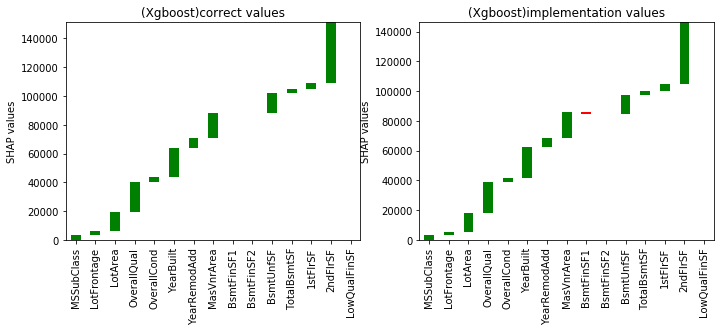

              correct values  implementation values difference(%)
MSSubClass           3653.39                3381.05         8.05%
LotFrontage          2303.45                1990.44        15.73%
LotArea             13188.90               12817.15          2.9%
OverallQual         20944.41               20638.99         1.48%
OverallCond          3292.49                2984.01        10.34%
YearBuilt           20719.08               20396.22         1.58%
YearRemodAdd         6479.38                6139.06         5.54%
MasVnrArea          17686.99               17424.19         1.51%
BsmtFinSF1              0.00               -1352.83        100.0%
BsmtFinSF2              0.00                   0.00          0.0%
BsmtUnfSF           13465.99               13177.93         2.19%
TotalBsmtSF          3077.40                2785.78        10.47%
1stFlrSF             4458.34                4175.96         6.76%
2ndFlrSF            41893.00               41644.48          0.6%
LowQualFin

In [16]:
print(Get_Explaination(20))

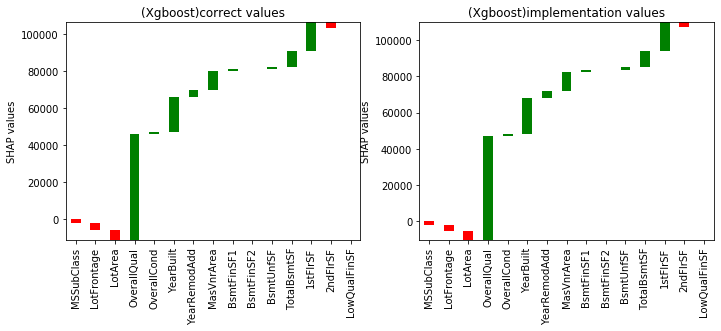

              correct values  implementation values difference(%)
MSSubClass          -2270.96               -1986.89         14.3%
LotFrontage         -3451.20               -3177.58         8.61%
LotArea             -5427.31               -5143.46         5.52%
OverallQual         57199.46               57489.96         0.51%
OverallCond           832.19                1138.42         26.9%
YearBuilt           19337.11               19618.56         1.43%
YearRemodAdd         3729.29                4021.94         7.28%
MasVnrArea          10276.16               10566.28         2.75%
BsmtFinSF1            966.14                1247.32        22.54%
BsmtFinSF2              0.00                   0.00          0.0%
BsmtUnfSF            1295.79                1594.00        18.71%
TotalBsmtSF          8223.54                8496.29         3.21%
1stFlrSF            15718.59               15993.21         1.72%
2ndFlrSF            -3058.08               -2771.26        10.35%
LowQualFin

In [17]:
print(Get_Explaination(34))